# Paradigm Free Mapping vs Total Activation: a comparison of the two methods

The main objective of this work is to compare the Paradigm Free Mapping and Total Activation methods. This allows us to see in what conditions they struggle/succeed in correctly estimating neuronal-related activity. This is a key step in better understanding both algorithms and will provide a better foundation for the development of new features in the future. 

This notebook explores the different $\lambda$ selection techniques used by the two methods; i.e. the Bayesian Information Criterion (BIC), the Akaike Information Criterion (AIC) and the $\lambda$ that makes the residual noise converge to a pre-estimated noise of the data. The former two cases are solved by means of the LARS algorithm, while the latter is solved with FISTA. All three cases are solved for two possible models: the spike model, that estimates the activity-inducing signal; and the block model, that estimates the innovation signal; i.e. the derivative of the activity-inducing signal.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pywt import wavedec
from scipy.signal import find_peaks
from scipy.stats import median_absolute_deviation
from sklearn.linear_model import lars_path, Lasso

from Scripts.debiasing import debiasing_int as debiasing
from Scripts.fista_update import fista_update as fista
from Scripts.hrf_matrix import HRFMatrix
from Scripts.temporal_ta import filter_boundary as ta_filter
from Scripts.total_activation import total_activation as ta
from Scripts.total_activation import hrf_filters

## Load data

In [2]:
# Data parameters needed for TA
params = {'tr': 2, 'cost_save': True, 'te': [0]}
# Path to data and ground truth .npy files
data = np.load('data/simulation_data_long_lownoise.npy')
ground_truth = np.load('data/simulation_bold_long_lownoise.npy')[:,0]

# Extract number of TRs and voxels
nscans = data.shape[0]
nvoxels = data.shape[1]
print(f'Data has {nscans} TRs and {nvoxels} voxels')

Data has 300 TRs and 8 voxels


## Plot first voxel in data

Text(0, 0.5, 'Amplitude (SPC)')

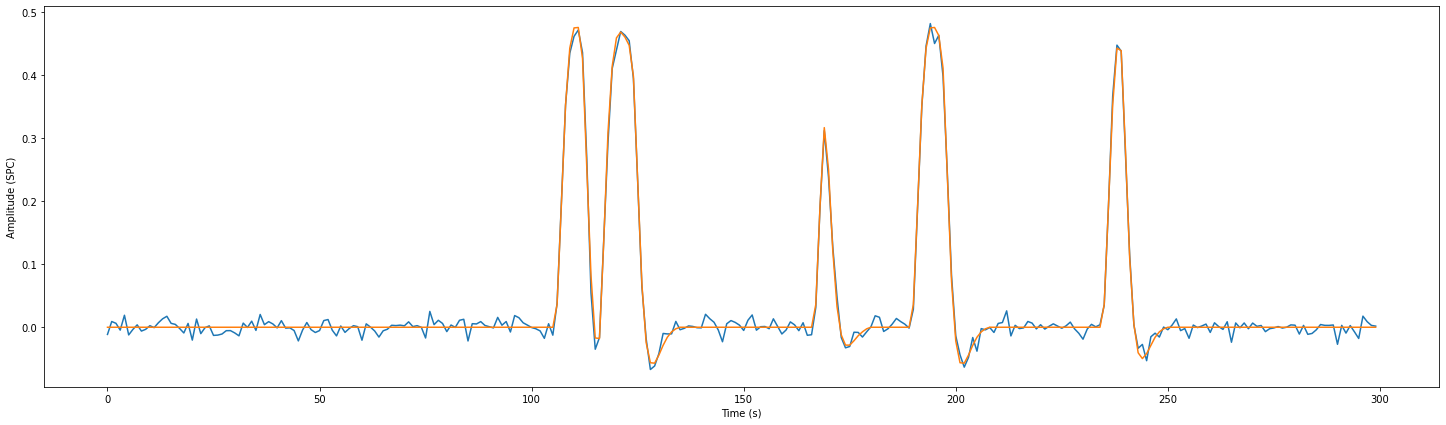

In [3]:
plt.figure(figsize=(25,7))
plt.plot(data[:, 0])
plt.plot(ground_truth)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (SPC)')

## Comparison of the default HRF shape in PFM and TA

In order to make a fair comparison, both techniques must use the same shape of the Haemodynamic Response Function (HRF). As you can see in the plot below, the default HRF shapes used by PFM and TA differ. More importantly, their peaks are spaced by one TR. This mismatch in the peak can also be seen in the estimates in low noise conditions.

/Users/enekourunuela/pfm_vs_ta/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


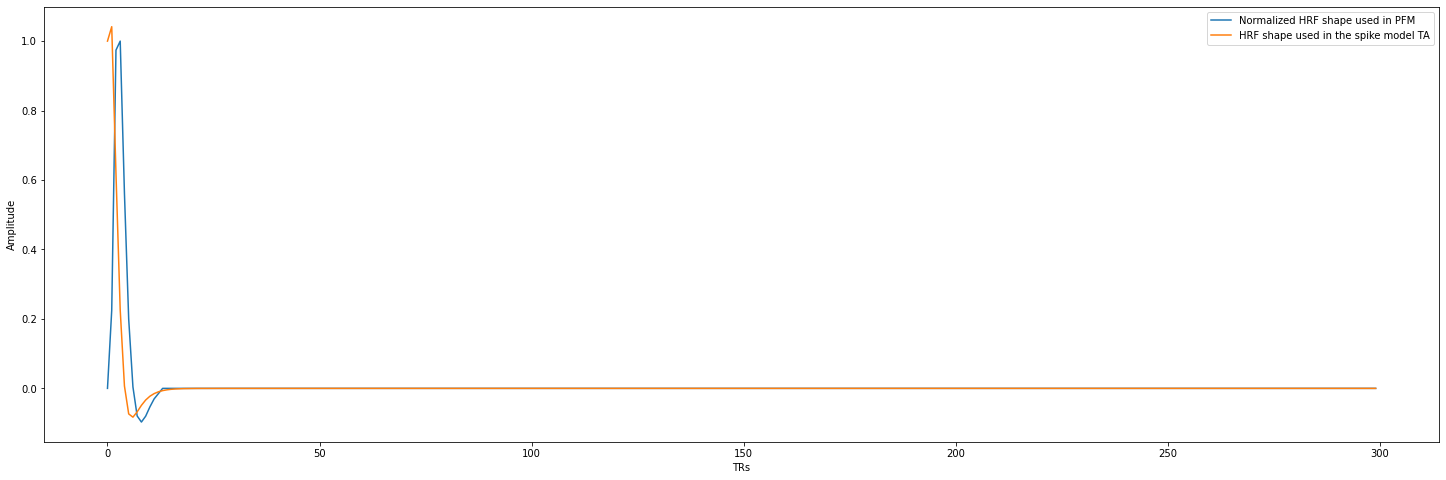

In [4]:
# Generate impulse
test_data = np.zeros(nscans)
test_data[int(0/params['tr'])] = 1

# Generate design matrix (shifted HRFs) for PFM with the spike model
hrf_matrix = HRFMatrix(TR=params['tr'], TE=params['te'], nscans=nscans, r2only=True, has_integrator=False, is_afni=True, lop_hrf='SPMG1')
hrf_matrix.generate_hrf()
hrf = hrf_matrix.X_hrf_norm

# Generate hrf filter for TA with spike model
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'], condition2='spmhrf')
n = params['f_recons']['den'][0]
d = [np.array(params['f_recons']['num']), 1]

# Convolve the impulse with the HRF
bold_pfm = np.dot(hrf, test_data)
bold_ta = np.real(ta_filter(n, d, test_data.T, 'normal', nscans))

# Plots both HRF shapes
plt.figure(figsize=(25,8))
plt.plot(bold_pfm, label='Normalized HRF shape used in PFM')
plt.plot(bold_ta, label='HRF shape used in the spike model TA')
plt.xlabel('TRs')
plt.ylabel('Amplitude')
plt.legend()

## Generate design matrix for PFM using TA HRF shape

Text(0, 0.5, 'Amplitude')

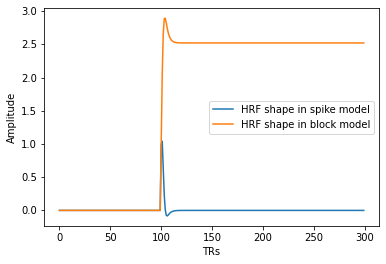

In [5]:
# Concatenate shifted HRFs into matrix for PFM design matrix.
# The TA shape generated above is used!!!
append_2 = 2*nscans - len(bold_ta)
temp = np.append(bold_ta, np.zeros(append_2))
for i in range(nscans-1):
    foo = np.append(np.zeros(i+1), bold_ta)
    append_2 = 2*nscans - len(foo)
    foo = np.append(foo, np.zeros(append_2))
    temp = np.column_stack((temp, foo))

# Only keep nscans x nscans matrix. The rest is just zero padding.
hrf = temp[:nscans, :nscans]

# Generate the design matrix for the block model in PFM
# by multiplying the shifted HRFs with an integration operator.
hrf_block = np.dot(hrf, np.tril(np.ones(nscans)))

# Plot one of the shifted HRFs for the sake of checking.
plt.plot(hrf[:, 100], label='HRF shape in spike model')
plt.plot(hrf_block[:, 100], label='HRF shape in block model')
plt.legend()
plt.xlabel('TRs')
plt.ylabel('Amplitude')

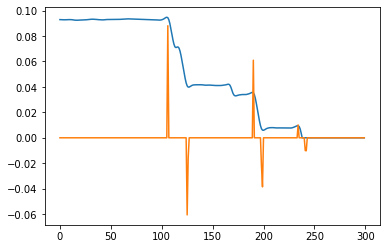

In [27]:
y = data[:, 0]
y = y[:, np.newaxis]

lambda_value = 2
fista_coef, _, _ = fista(hrf_block, y, max_iter=100000, lambd=lambda_value, update_lambda=False, precision=1e-6)

clf = Lasso(alpha=lambda_value/nscans)
clf.fit(hrf_block, y)
sklearn_coef = clf.coef_
    
plt.plot(fista_coef*1000)
plt.plot(sklearn_coef)

## Define function to find closest value in an array

This function is used to find the optimal lambda --found when the residual noise converges to a pre-estimated noise of the data-- in the LARS path.

In [7]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

## PFM vs TA with noise estimate and updating lambda (spike model)

First of all, we're going to compare the methods making the residual noise converge to a pre-estimated noise of the data; with the spike model first and the block model after.

In [8]:
# Generate HRF filter for TA with block model
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'])
n = params['f_analyze']['num']
d = params['f_analyze']['den']

# Ideally we would do this for every voxel in the dataset.
# For the sake of comparing, doing it with just one voxel is enough at the moment.
for vox_idx in range(1):
    
    # Extract voxel data
    y = data[:, vox_idx]
    y = y[:, np.newaxis]
    
    # Calculate maximum lambda possible
    pfm_spike_max_lambda = np.max(np.dot(hrf.T, y))
    print(f'Max lambda: {pfm_spike_max_lambda}')
    
    # Estimate noise and use it as initial value of lambda
    _, cD1 = wavedec(y, 'db3', level=1, axis=0)
    noise_estimate = np.median(abs(cD1 - np.median(cD1))) / 0.8095
    print(f'Initial lambda: {noise_estimate}')
    
    # Solve FISTA for PFM and save estimated coefficients and optimal lambda; i.e. the lambda that made the residual noise converge
    pfm_spikes, _, pfm_spike_lambda = fista(hrf, y, max_iter=100, lambd=noise_estimate, update_lambda=True)
    pfm_spike_lambda_est = pfm_spike_lambda[0]
    print(f'PFM optimal lambda: {pfm_spike_lambda_est}')
    
    # Solve TA and save estimated coefficients and optimal lambda; i.e. the lambda that made the residual noise converge
    ta_spikes, ta_spike_lambda = ta(y, params, lambd=noise_estimate, update_lambda=True)
    ta_spike_lambda_est = ta_spike_lambda[0]
    print(f'TA optimal lambda: {ta_spike_lambda_est}')

/Users/enekourunuela/pfm_vs_ta/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


Max lambda: 1.332960758832317
Initial lambda: 0.007264100238617776
PFM optimal lambda: 0.028341988516941283
TA optimal lambda: 0.013183492876733942


We're going to plot the estimated time-series of both methods. Only non-zero values are shown. 

Text(0.5, 1.0, 'TA spike model with noise estimation')

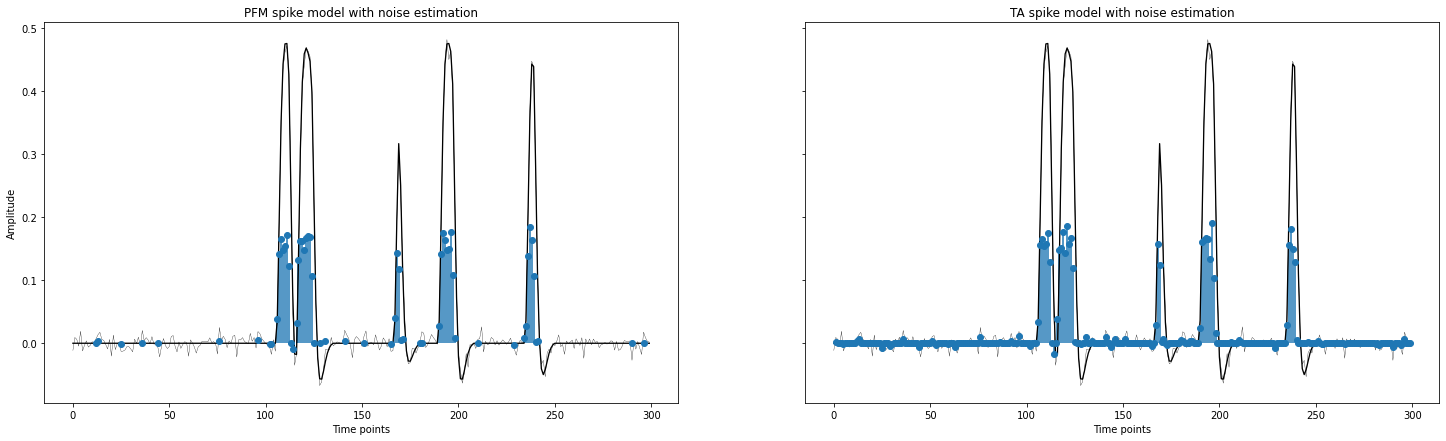

In [9]:
# Set zeros to nan to avoid them being shown in the plot
pfm_spikes_plot = pfm_spikes.copy()
pfm_spikes_plot[pfm_spikes_plot == 0] = np.nan
ta_spikes_plot = ta_spikes.copy()
ta_spikes_plot[ta_spikes_plot == 0] = np.nan

# Create plot
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,7))
# Plots PFM results
ax1.plot(y, color='black', linewidth=.3, label='Simulation')
ax1.plot(ground_truth, color='black', linewidth='1.3', label='Ground truth')
ax1.stem(pfm_spikes_plot, label='PFM', use_line_collection=True, basefmt=" ")
ax1.set(xlabel='Time points', ylabel='Amplitude')
ax1.set_title('PFM spike model with noise estimation')

# Plot TA results
ax2.plot(y, color='black', linewidth=.3, label='Simulation')
ax2.plot(ground_truth, color='black', linewidth='1.3', label='Ground truth')
ax2.stem(ta_spikes_plot, label='TA', use_line_collection=True, basefmt=" ")
ax2.set(xlabel='Time points')
ax2.set_title('TA spike model with noise estimation')

As you can see, the estimated time-series are incredibly similar. The main difference is TA yields more non-zero values. However, these are neglectable and easily thresholded. Another difference is the optimal $\lambda$ value each of the methods converge with. PFM converges to a slighly higher value of $\lambda$ (0.028 > 0.013). Mind that the highest value of $\lambda$, i.e. the one that 

## PFM vs TA with noise estimate and updating lambda (block model)

Now, we're going to compare the methods using the block model, in the same fashion as above.

In [10]:
# Generate HRF filter for TA with block model
params['model'] = 'block'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'])
n = params['f_analyze']['num']
d = params['f_analyze']['den']

# Ideally we would do this for every voxel in the dataset.
# For the sake of comparing, doing it with just one voxel is enough at the moment.
for vox_idx in range(1):
    
    # Extract voxel data
    y = data[:, vox_idx]
    y = y[:, np.newaxis]
    
    # Calculate maximum lambda possible
    pfm_block_max_lambda = np.max(np.dot(hrf_block.T, y))
    print(f'Max lambda: {pfm_block_max_lambda}')
    
    # Estimate noise and use it as initial value of lambda
    _, cD1 = wavedec(y, 'db3', level=1, axis=0)
    noise_estimate = np.median(abs(cD1 - np.median(cD1))) / 0.8095
    print(f'Initial lambda: {noise_estimate}')
    
    # Solve FISTA for PFM and save estimated coefficients and optimal lambda; i.e. the lambda that made the residual noise converge
    pfm_block, _, pfm_block_lambda = fista(hrf_block, y, max_iter=100, lambd=noise_estimate, update_lambda=True, precision=1e-3)
    pfm_block_lambda_est = pfm_block_lambda[0]
    print(f'PFM optimal lambda: {pfm_block_lambda_est}')
    
    # Solve TA and save estimated coefficients and optimal lambda; i.e. the lambda that made the residual noise converge
    ta_block, ta_block_lambda = ta(y, params, lambd=noise_estimate, update_lambda=True)
    ta_block_lambda_est = ta_block_lambda[0]
    print(f'TA optimal lambda: {ta_block_lambda_est}')

/Users/enekourunuela/pfm_vs_ta/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


Max lambda: 29.255555178999852
Initial lambda: 0.007264100238617776
PFM optimal lambda: 0.7962841807925787
TA optimal lambda: 0.009336845920055696


We're going to plot the estimated time-series of both methods. Only non-zero values are shown. 

Text(0.5, 1.0, 'TA block model with noise estimation')

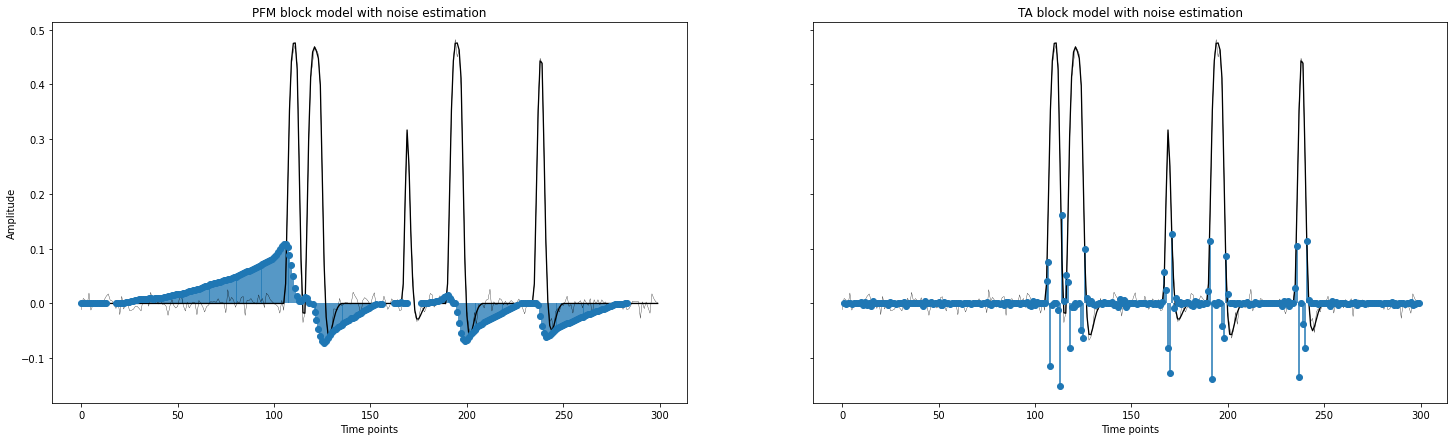

In [11]:
# Set zeros to nan to avoid them being shown in the plot
pfm_block_plot = pfm_block
pfm_block_plot[pfm_block_plot == 0] = np.nan
ta_block_plot = ta_block
ta_block_plot[ta_block_plot == 0] = np.nan
pfm_block_plot *= 100

# Create plot
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,7))

# Plot PFM results
ax1.plot(y, color='black', linewidth=.3, label='Simulation')
ax1.plot(ground_truth, color='black', linewidth='1.3', label='Ground truth')
ax1.stem(pfm_block_plot, label='PFM', use_line_collection=True, basefmt=" ")
ax1.set(xlabel='Time points', ylabel='Amplitude')
ax1.set_title('PFM block model with noise estimation')

# Plot TA results
ax2.plot(y, color='black', linewidth=.3, label='Simulation')
ax2.plot(ground_truth, color='black', linewidth='1.3', label='Ground truth')
ax2.stem(ta_block_plot, label='PFM', use_line_collection=True, basefmt=" ")
ax2.set(xlabel='Time points')
ax2.set_title('TA block model with noise estimation')

## Compare spike model PFM and TA with LARS

In this section we will compare the BIC and AIC techniques. First, we will solve the PFM model with LARS and then we will use the same regularization path; i.e. the same values of $\lambda$, on TA. Following the same order as in the previous section, we will solve the optimization problem for the spikes model first.

In [12]:
# Generate HRF filter for TA with spike model
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'])
n = params['f_analyze']['num']
d = params['f_analyze']['den']

# The optimal solution should be found before half of the LARS steps are performed.
nlambdas = int(0.5*nscans)

for vox_idx in range(1):
    print(f'Running LARS for PFM on voxel {vox_idx + 1} of {nvoxels}...')
    
    # Extract voxel data
    y = data[:, vox_idx]
    y = y[:, np.newaxis]
    
    # Calculate the maximum lambda possible to compare with BIC and AIC ones.
    pfm_max_lambda = np.max(np.dot(hrf.T, y))
    print(f'PFM max lambda: {pfm_max_lambda}')
    
    #Solve LARS on PFM and save coefficients and lambdas
    lambdas_pfm_spike, _, pfm_spike_coef_path = lars_path(hrf, np.squeeze(y), method = 'lasso', Gram = np.dot(hrf.T, hrf),
                                                          Xy = np.dot(hrf.T, np.squeeze(y)), max_iter = nlambdas-1, eps=1e-9)
    
    # Given that sklearn divides by the number of scans, we must update our range of lambdas accordingly
    # See https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lars.html
    lambdas_pfm_spike *= nscans
    
    # Set low coefficients to zero for cleaner results.
    pfm_spike_coef_path[abs(pfm_spike_coef_path) < 1e-3] = 0
    
    # Calculate residuals for BIC and AIC calculation
    L2res_pfm = np.sum((np.repeat(y, nlambdas, axis=-1) - np.dot(hrf, pfm_spike_coef_path))**2, axis=0)
    bic_pfm_spike = nscans*np.log(L2res_pfm) + np.log(nscans)*np.count_nonzero(pfm_spike_coef_path, axis=0)
    aic_pfm_spike = nscans*np.log(L2res_pfm) + 2*np.count_nonzero(pfm_spike_coef_path, axis=0)
    
    # Calculate regularization path for TA with same lambdas as PFM
    print(f'Calculating regularization path for TA on voxel {vox_idx + 1} of {nvoxels}...')
    lambdas_ta_spike = lambdas_pfm_spike.copy()
    ta_spike_coef_path = np.zeros(pfm_spike_coef_path.shape) # Shape: nscans x nlambdas
    for lambda_idx in range(nlambdas):
        temp, _ = ta(y, params, lambd=lambdas_ta_spike[lambda_idx])
        ta_spike_coef_path[:, lambda_idx] = np.squeeze(temp)
        
    # Set low coefficients to zero for cleaner results.
    ta_spike_coef_path[abs(ta_spike_coef_path) < 1e-3] = 0
    
    # Calculate residuals for BIC and AIC calculation
    L2res_ta = np.sum((np.repeat(y, nlambdas, axis=-1) - np.dot(hrf, ta_spike_coef_path))**2, axis=0)
    bic_ta_spike = nscans*np.log(L2res_ta) + np.log(nscans)*np.count_nonzero(ta_spike_coef_path, axis=0)
    aic_ta_spike = nscans*np.log(L2res_ta) + 2*np.count_nonzero(ta_spike_coef_path, axis=0)
    
    print(f'Regularization path of voxel {vox_idx + 1} calculated')
    

/Users/enekourunuela/pfm_vs_ta/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


Running LARS for PFM on voxel 1 of 8...
PFM max lambda: 1.332960758832317
Calculating regularization path for TA on voxel 1 of 8...
Regularization path of voxel 1 calculated


We now calculate the optimal $\lambda$ based on the AIC and BIC curves for each of the methods; i.e. for PFM and TA.

In [13]:
# Find where the optimal falls in the BIC and AIC curves; i.e. where the minimum is.
bic_pfm_spike_idx = np.argmin(bic_pfm_spike)
aic_pfm_spike_idx = np.argmin(aic_pfm_spike)
bic_ta_spike_idx = np.argmin(bic_ta_spike)
aic_ta_spike_idx = np.argmin(aic_ta_spike)

# Find where the estimated lambda from the previous section falls in the LARS regularization path.
# We use the closest value to it to make it easier to plot.
pfm_spike_lambda_est = find_nearest(lambdas_pfm_spike, pfm_spike_lambda_est)
pfm_spike_lambda_est_idx = np.where(lambdas_pfm_spike == pfm_spike_lambda_est)[0]
ta_spike_lambda_est = find_nearest(lambdas_ta_spike, ta_spike_lambda_est)
ta_spike_lambda_est_idx = np.where(lambdas_ta_spike == ta_spike_lambda_est)[0]

### Plot comparison of spike model regularization path

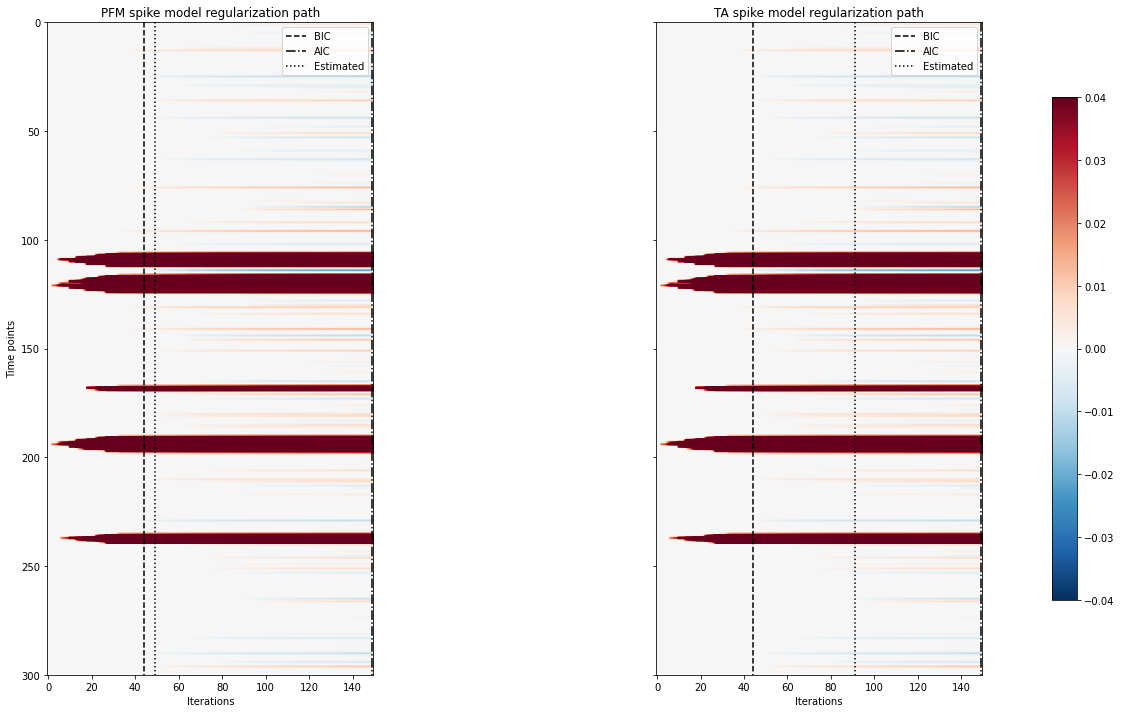

In [16]:
# Minimum and maximum amplitude shown in the heatmap
plot_amplitude = 0.04

# Generate figure
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,12))

# Plot heatmap of entire regularization path for PFM
im = ax1.imshow(pfm_spike_coef_path, cmap='RdBu_r', vmin=-plot_amplitude, vmax=plot_amplitude)

# Plot vertical lines to indicate BIC, AIC and estimated lambdas.
ax1.vlines(x=bic_pfm_spike_idx, ymin=0, ymax=nscans, color='black', linestyles='dashed', label='BIC')
ax1.vlines(x=aic_pfm_spike_idx, ymin=0, ymax=nscans, color='black', linestyles='dashdot', label='AIC')
ax1.vlines(x=pfm_spike_lambda_est_idx, ymin=0, ymax=nscans, color='black', linestyles='dotted', label='Estimated')
ax1.set_ylim([300, 0])
ax1.legend()
ax1.set(xlabel='Iterations', ylabel='Time points')
ax1.set_title('PFM spike model regularization path')

# Plot heatmap of entire regularization path for TA
ax2.imshow(ta_spike_coef_path, cmap='RdBu_r', vmin=-plot_amplitude, vmax=plot_amplitude)

# Plot vertical lines to indicate BIC, AIC and estimated lambdas.
ax2.vlines(x=bic_ta_spike_idx, ymin=0, ymax=nscans, color='black', linestyles='dashed', label='BIC')
ax2.vlines(x=aic_ta_spike_idx, ymin=0, ymax=nscans, color='black', linestyles='dashdot', label='AIC')
ax2.vlines(x=ta_spike_lambda_est_idx, ymin=0, ymax=nscans, color='black', linestyles='dotted', label='Estimated')
ax2.set_ylim([300, 0])
ax2.legend()
ax2.set(xlabel='Iterations')
ax2.set_title('TA spike model regularization path')

# Add colorbar
fig.colorbar(im, ax=[ax1, ax2], shrink=0.77)

We can see that both PFM and TA yield (almost?) identical results when solving the problem for the spike model with the same values of $\lambda$ and the same shape of the HRF. The X axis shows the regularization path from the highest to the lowest $\lambda$ and the color bar indicates the amplitude of each time-point. In this case, the BIC and AIC selection of $\lambda$ fall in the same value respectively for both PFM and TA. The optimal solution would be the one given by the BIC selection as only the true events would be detected (the ones to the left of the vertical line of BIC). The following plot shows where this BIC, AIC and estimated values fall in the range of $\lambda$ in the regularization path.

Text(0.5, 1.0, 'TA spike model lambdas')

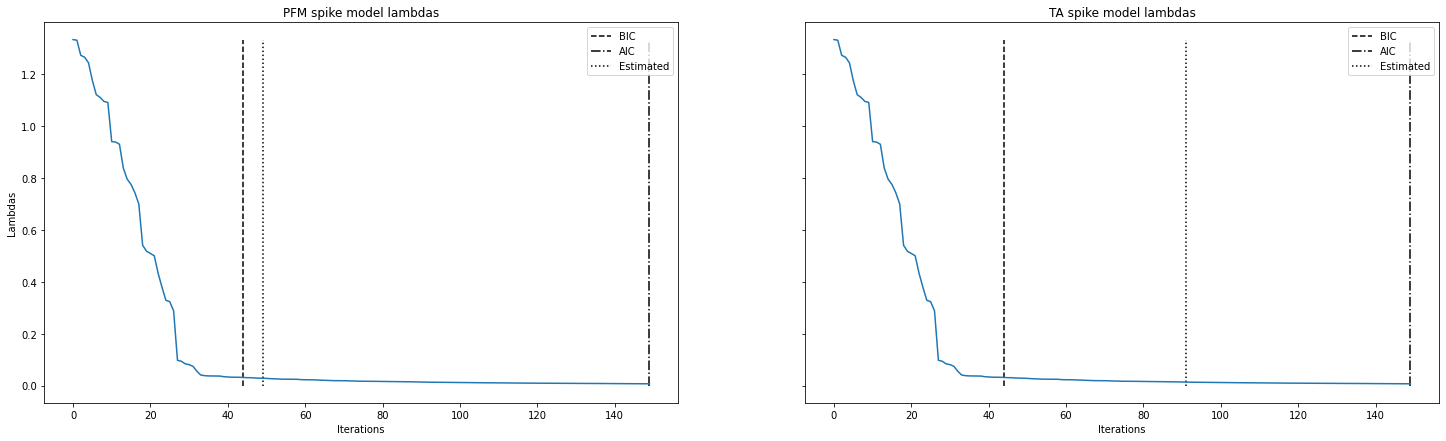

In [17]:
# Generate figure.
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,7))

# Plot curve of lambdas for PFM.
ax1.plot(lambdas_pfm_spike)

# Plot vertical lines with BIC, AIC and estimated selections.
ax1.vlines(x=bic_pfm_spike_idx, ymin=0, ymax=pfm_max_lambda, color='black', linestyles='dashed', label='BIC')
ax1.vlines(x=aic_pfm_spike_idx, ymin=0, ymax=pfm_max_lambda, color='black', linestyles='dashdot', label='AIC')
ax1.vlines(x=pfm_spike_lambda_est_idx, ymin=0, ymax=pfm_max_lambda, color='black', linestyles='dotted', label='Estimated')
ax1.legend()
ax1.set(xlabel='Iterations', ylabel='Lambdas')
ax1.set_title('PFM spike model lambdas')

# Plot curve of lambdas for TA.
ax2.plot(lambdas_ta_spike)

# Plot vertical lines with BIC, AIC and estimated selections.
ax2.vlines(x=bic_ta_spike_idx, ymin=0, ymax=pfm_max_lambda, color='black', linestyles='dashed', label='BIC')
ax2.vlines(x=aic_ta_spike_idx, ymin=0, ymax=pfm_max_lambda, color='black', linestyles='dashdot', label='AIC')
ax2.vlines(x=ta_spike_lambda_est_idx, ymin=0, ymax=pfm_max_lambda, color='black', linestyles='dotted', label='Estimated')
ax2.legend()
ax2.set(xlabel='Iterations')
ax2.set_title('TA spike model lambdas')

The plot below shows the BIC and AIC curves of PFM and TA. We can see the curves and BIC and AIC selections are identical.

Text(0.5, 1.0, 'PFM vs TA: AIC with spikes')

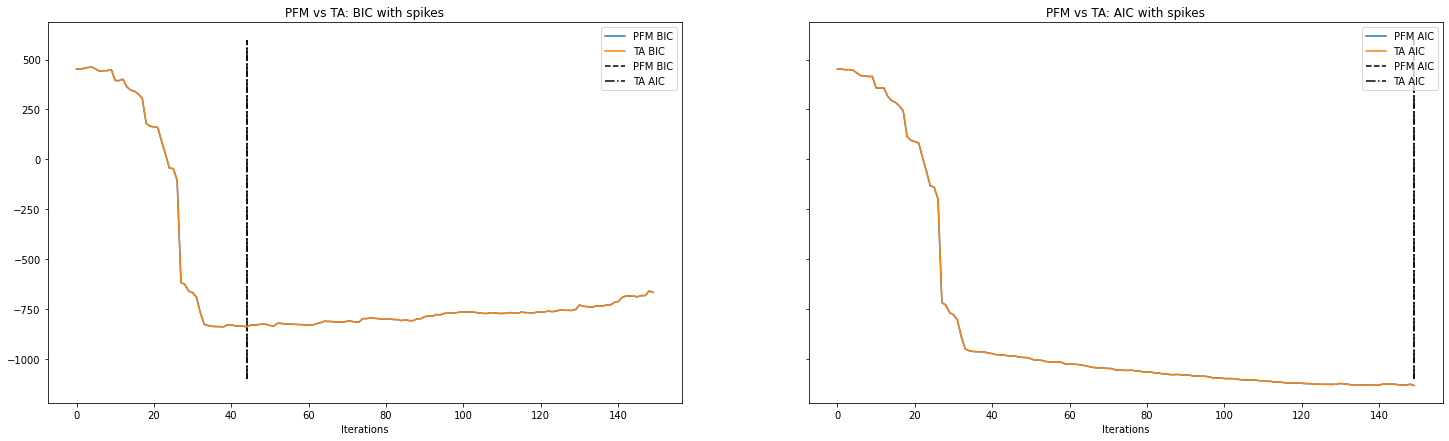

In [18]:
# Generate figure.
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,7))

# Plot BIC curves of PFM and TA.
ax1.plot(bic_pfm_spike, label='PFM BIC')
ax1.plot(bic_ta_spike, label='TA BIC')

# Plot vertical lines with BIC selection for PFM and TA.
ax1.vlines(x=bic_pfm_spike_idx, ymin=-1100, ymax=600, color='black', linestyles='dashed', label='PFM BIC')
ax1.vlines(x=bic_ta_spike_idx, ymin=-1100, ymax=600, color='black', linestyles='dashdot', label='TA AIC')
ax1.set(xlabel='Iterations')
ax1.set_title('PFM vs TA: BIC with spikes')
ax1.legend()

# Plot AIC curves of PFM and TA.
ax2.plot(aic_pfm_spike, label='PFM AIC')
ax2.plot(aic_ta_spike, label='TA AIC')

# Plot vertical lines with BIC selection for PFM and TA.
ax2.vlines(x=aic_pfm_spike_idx, ymin=-1100, ymax=600, color='black', linestyles='dashed', label='PFM AIC')
ax2.vlines(x=aic_ta_spike_idx, ymin=-1100, ymax=600, color='black', linestyles='dashdot', label='TA AIC')
ax2.set(xlabel='Iterations')
ax2.legend()
ax2.set_title('PFM vs TA: AIC with spikes')

## Compare block model PFM and TA with LARS

As we did before, we will compare the BIC and AIC techniques with the block model now. First, we will solve the PFM model with LARS and then we will use the same regularization path; i.e. the same values of 𝜆 , on TA.

In [20]:
# Generate HRF filter for TA with block model
params['model'] = 'block'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'])
n = params['f_analyze']['num']
d = params['f_analyze']['den']

nlambdas = int(0.5*nscans)

for vox_idx in range(1): #range(nvoxels):
    print(f'Running LARS for PFM on voxel {vox_idx + 1} of {nvoxels}...')
    
    # Extract voxel data
    y = data[:, vox_idx]
    y = y[:, np.newaxis]
    
    # Calculate maximum lambda possible
    pfm_max_lambda = np.max(np.dot(hrf_block.T, y))
    print(f'PFM max lambda: {pfm_max_lambda}')
    
    # Solve LARS for PFM
    lambdas_pfm_block, _, pfm_block_coef_path = lars_path(hrf_block, np.squeeze(y), method = 'lasso', Gram = np.dot(hrf_block.T, hrf_block),
                                                          Xy = np.dot(hrf_block.T, np.squeeze(y)), max_iter = nlambdas-1, eps=1e-9)
    
    # Given that sklearn divides by the number of scans, we must update our range of lambdas accordingly
    # See https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lars.html
    lambdas_pfm_block *= nscans
    
    # Threshold low coefficients to make results cleaner
    pfm_block_coef_path[abs(pfm_block_coef_path) < 1e-3] = 0
    
    # Calculate residuals for calculation of BIC and AIC curves
    L2res_pfm = np.sum((np.repeat(y, nlambdas, axis=-1) - np.dot(hrf_block, pfm_block_coef_path))**2, axis=0)
    bic_pfm_block = nscans*np.log(L2res_pfm) + np.log(nscans)*np.count_nonzero(pfm_block_coef_path, axis=0)
    aic_pfm_block = nscans*np.log(L2res_pfm) + 2*np.count_nonzero(pfm_block_coef_path, axis=0)
    
    # Calculates regularization path for TA
    print(f'Calculating regularization path for TA on voxel {vox_idx + 1} of {nvoxels}...')
    lambdas_ta_block = lambdas_pfm_block.copy()
    ta_block_coef_path = np.zeros(pfm_block_coef_path.shape) # Shape: nscans x nlambdas
    for lambda_idx in range(nlambdas):
        temp, _ = ta(y, params, lambd=lambdas_ta_block[lambda_idx])
        ta_block_coef_path[:, lambda_idx] = np.squeeze(temp)
    
    # Threshold low coefficients to make results cleaner
    ta_block_coef_path[abs(ta_block_coef_path) < 1e-3] = 0
    
    # Calculate residuals for calculation of BIC and AIC curves
    L2res_ta = np.sum((np.repeat(y, nlambdas, axis=-1) - np.dot(hrf_block, ta_block_coef_path))**2, axis=0)
    bic_ta_block = nscans*np.log(L2res_ta) + np.log(nscans)*np.count_nonzero(ta_block_coef_path, axis=0)
    aic_ta_block = nscans*np.log(L2res_ta) + 2*np.count_nonzero(ta_block_coef_path, axis=0)
    
    print(f'Regularization path of voxel {vox_idx + 1} calculated')

/Users/enekourunuela/pfm_vs_ta/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


Running LARS for PFM on voxel 1 of 8...
PFM max lambda: 29.255555178999852
Calculating regularization path for TA on voxel 1 of 8...
Regularization path of voxel 1 calculated


In [21]:
# Find where the optimal falls in the BIC and AIC curves; i.e. where the minimum is.
bic_pfm_block_idx = np.argmin(bic_pfm_block)
aic_pfm_block_idx = np.argmin(aic_pfm_block)
bic_ta_block_idx = np.argmin(bic_ta_block)
aic_ta_block_idx = np.argmin(aic_ta_block)

# Find where the estimated lambda from the previous section falls in the LARS regularization path.
# We use the closest value to it to make it easier to plot.
pfm_block_lambda_est_idx = find_nearest(lambdas_pfm_block, pfm_block_lambda_est)
pfm_block_lambda_est_idx = np.where(lambdas_pfm_block == pfm_block_lambda_est)[0]
ta_block_lambda_est_idx = find_nearest(lambdas_ta_block, ta_block_lambda_est)
ta_block_lambda_est_idx = np.where(lambdas_ta_block == ta_block_lambda_est)[0]

### Plot comparison of block model regularization path

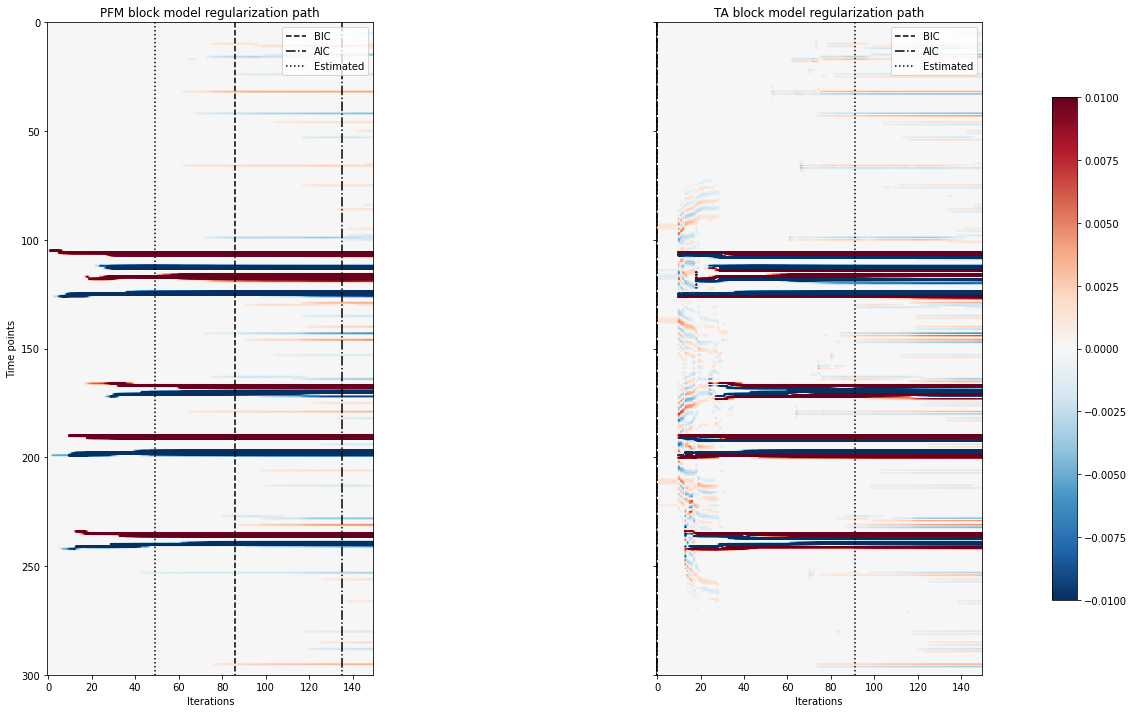

In [29]:
# Minimum and maximum amplitude shown in the heatmap
plot_amplitude = 0.01

# Generate figure.
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,12))

# Plot heatmap of entire regularization path for PFM.
im = ax1.imshow(pfm_block_coef_path, cmap='RdBu_r', vmin=-plot_amplitude, vmax=plot_amplitude)

# Plot vertical lines to indicate BIC, AIC and estimated lambdas.
ax1.vlines(x=bic_pfm_block_idx, ymin=0, ymax=nscans, color='black', linestyles='dashed', label='BIC')
ax1.vlines(x=aic_pfm_block_idx, ymin=0, ymax=nscans, color='black', linestyles='dashdot', label='AIC')
ax1.vlines(x=pfm_spike_lambda_est_idx, ymin=0, ymax=nscans, color='black', linestyles='dotted', label='Estimated')
ax1.set_ylim([300, 0])
ax1.legend()
ax1.set(xlabel='Iterations', ylabel='Time points')
ax1.set_title('PFM block model regularization path')

# Plot heatmap of entire regularization path for PFM.
ax2.imshow(ta_block_coef_path, cmap='RdBu_r', vmin=-plot_amplitude, vmax=plot_amplitude)

# Plot vertical lines to indicate BIC, AIC and estimated lambdas.
ax2.vlines(x=bic_ta_block_idx, ymin=0, ymax=nscans, color='black', linestyles='dashed', label='BIC')
ax2.vlines(x=aic_ta_block_idx, ymin=0, ymax=nscans, color='black', linestyles='dashdot', label='AIC')
ax2.vlines(x=ta_spike_lambda_est_idx, ymin=0, ymax=nscans, color='black', linestyles='dotted', label='Estimated')
ax2.set_ylim([300, 0])
ax2.legend()
ax2.set(xlabel='Iterations')
ax2.set_title('TA block model regularization path')

# Add colorbar
fig.colorbar(im, ax=[ax1, ax2], shrink=0.77)

We can see that both PFM and TA yield somehow different results when solving the problem for the block model with the same values of $\lambda$ and the same shape of the HRF. The X axis shows the regularization path from the highest to the lowest $\lambda$ and the color bar indicates the amplitude of each time-point. While PFM correctly estimates the positive and negative spikes of the innovation signals, TA estimates a pair of positive and negative spikes for each of the changes in innovation signal; i.e. for each positive spike in PFM, TA estimates a positive and a negative spike. Actually, the negative spikes show the inside of the event, while the positive ones show the outside. Moreover, we can see that some low amplitude estimates fluctuate in the higher range of $\lambda$ in the case of TA. These should be easily removed with a thresholding step. Another important point is the uncertainty on the exact time-point where the true events fall. This uncertainty is visible in the higher values of $\lambda$ and becomes more certain as $\lambda$ decreases.

In this case, the BIC and AIC selection of $\lambda$ fall in the null solution for TA, and thus, do not provide an optimal selection of $\lambda$. The optimal solution would be the one given by the PFM-estimated $\lambda$ from section one as only the true events would be detected (the ones to the left of the vertical line of BIC). The following plot shows where this BIC, AIC and estimated values fall in the range of $\lambda$ in the regularization path.

Text(0.5, 1.0, 'TA block model lambdas')

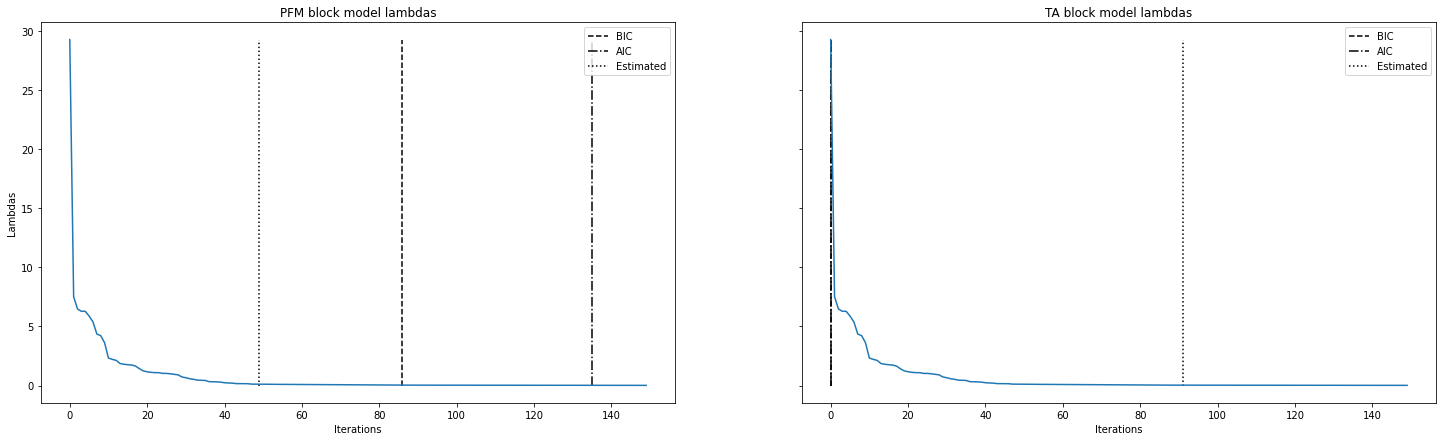

In [20]:
# Generate figure.
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,7))

# Plot curve of lambdas for PFM.
ax1.plot(lambdas_pfm_block)

# Plot vertical lines that show the BIC, AIC and estimated selection of lambda.
ax1.vlines(x=bic_pfm_block_idx, ymin=0, ymax=pfm_max_lambda, color='black', linestyles='dashed', label='BIC')
ax1.vlines(x=aic_pfm_block_idx, ymin=0, ymax=pfm_max_lambda, color='black', linestyles='dashdot', label='AIC')
ax1.vlines(x=pfm_spike_lambda_est_idx, ymin=0, ymax=pfm_max_lambda, color='black', linestyles='dotted', label='Estimated')
ax1.legend()
ax1.set(xlabel='Iterations', ylabel='Lambdas')
ax1.set_title('PFM block model lambdas')

# Plot curve of lambdas for TA.
ax2.plot(lambdas_ta_block)

# Plot vertical lines that show the BIC, AIC and estimated selection of lambda.
ax2.vlines(x=bic_ta_block_idx, ymin=0, ymax=pfm_max_lambda, color='black', linestyles='dashed', label='BIC')
ax2.vlines(x=aic_ta_block_idx, ymin=0, ymax=pfm_max_lambda, color='black', linestyles='dashdot', label='AIC')
ax2.vlines(x=ta_spike_lambda_est_idx, ymin=0, ymax=pfm_max_lambda, color='black', linestyles='dotted', label='Estimated')
ax2.legend()
ax2.set(xlabel='Iterations')
ax2.set_title('TA block model lambdas')

The plot below shows the BIC and AIC curves of PFM and TA. We can see the curves and BIC and AIC selections are different when we use the block model. TA favors the null solution on both the BIC and AIC selections, while the BIC and AIC selections appear further down the regularization path for PFM.

Text(0.5, 1.0, 'PFM vs TA: AIC with blocks')

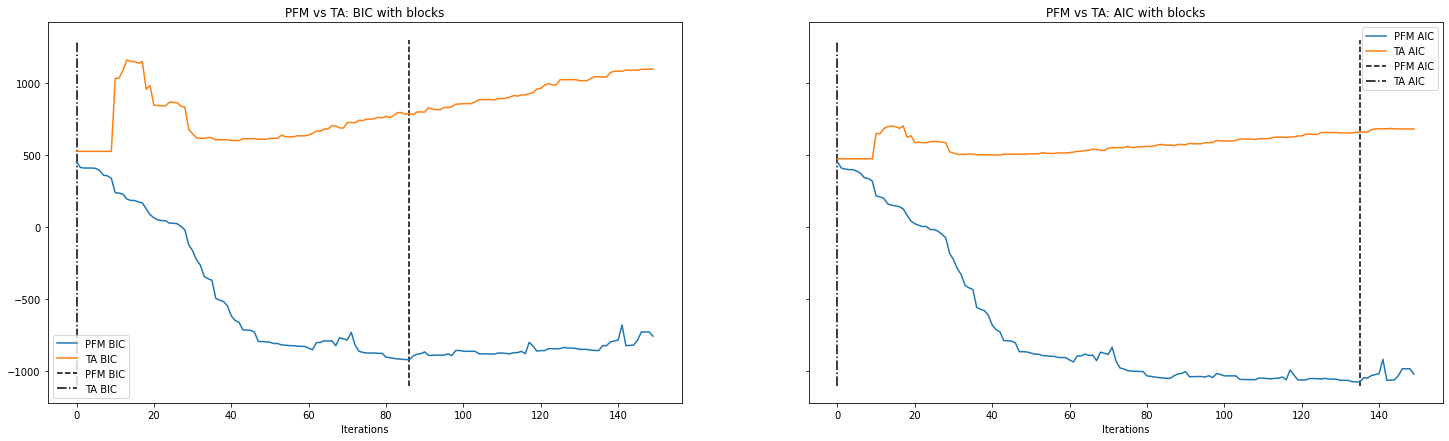

In [21]:
# Generate figure.
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,7))

# Plot BIC curves of PFM and TA
ax1.plot(bic_pfm_block, label='PFM BIC')
ax1.plot(bic_ta_block, label='TA BIC')

# Plot vertical line that shows BIC selection of PFM and TA.
ax1.vlines(x=bic_pfm_block_idx, ymin=-1100, ymax=1300, color='black', linestyles='dashed', label='PFM BIC')
ax1.vlines(x=bic_ta_block_idx, ymin=-1100, ymax=1300, color='black', linestyles='dashdot', label='TA BIC')
ax1.set(xlabel='Iterations')
ax1.set_title('PFM vs TA: BIC with blocks')
ax1.legend()

# Plot AIC curves of PFM and TA.
ax2.plot(aic_pfm_block, label='PFM AIC')
ax2.plot(aic_ta_block, label='TA AIC')

# Plot vertical line that shows AIC selection of PFM and TA.
ax2.vlines(x=aic_pfm_block_idx, ymin=-1100, ymax=1300, color='black', linestyles='dashed', label='PFM AIC')
ax2.vlines(x=aic_ta_block_idx, ymin=-1100, ymax=1300, color='black', linestyles='dashdot', label='TA AIC')
ax2.set(xlabel='Iterations')
ax2.legend()
ax2.set_title('PFM vs TA: AIC with blocks')

## Same lambda comparison based on BIC selection

Finally, we compare the performance of both methods under the same value of $\lambda$ selected with BIC in the previous section.

### Taking BIC lambda from PFM with spike model

In [54]:
# Generate hrf filter for TA with block model
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'])
n = params['f_analyze']['num']
d = params['f_analyze']['den']

for vox_idx in range(1):
    
    # Extract voxel data.
    y = data[:, vox_idx]
    y = y[:, np.newaxis]
    
    # Set lambda to PFM BIC selection.
    bic_lambda = lambdas_pfm_spike[bic_pfm_spike_idx]
    
    # Solve PFM. Lambda is divided by nscans to account for sklearn formulation.
    clf = Lasso(alpha=bic_lambda/nscans)
    clf.fit(hrf, y)
    pfm_spikes = clf.coef_
    
    # Solve TA.
    ta_spikes, ta_spike_lambda = ta(y, params, lambd=bic_lambda, update_lambda=False)

/Users/enekourunuela/pfm_vs_ta/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))
/Users/enekourunuela/pfm_vs_ta/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


Text(0.5, 1.0, 'TA spike model with noise estimation')

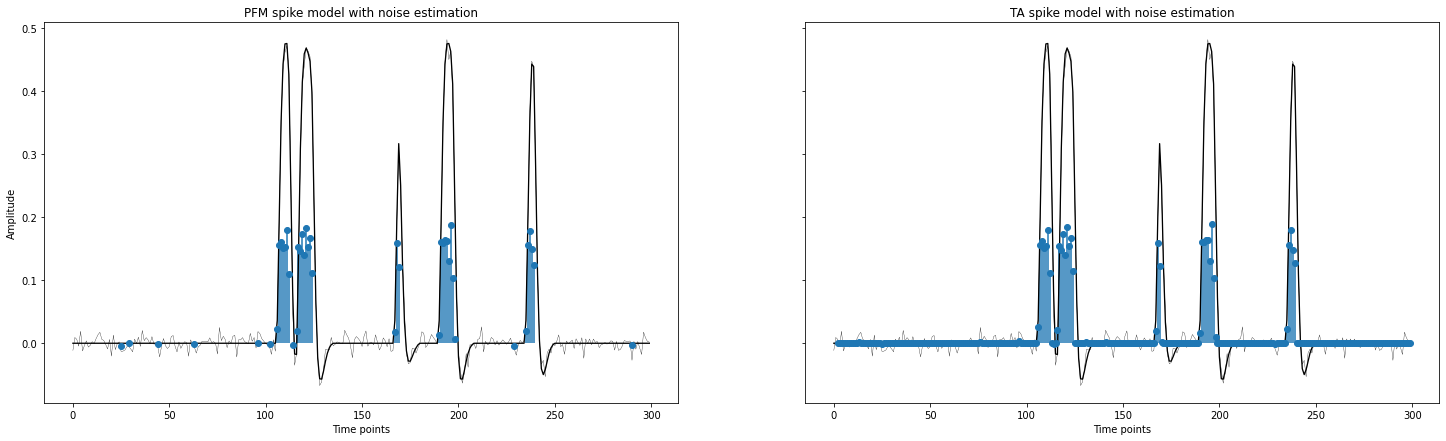

In [55]:
# Set zeros to nan to make plots cleaner.
pfm_spikes_plot = pfm_spikes.copy()
pfm_spikes_plot[pfm_spikes_plot == 0] = np.nan
ta_spikes_plot = ta_spikes.copy()
ta_spikes_plot[ta_spikes_plot == 0] = np.nan

# Generate figure.
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,7))

# Plot PFM results.
ax1.plot(y, color='black', linewidth=.3, label='Simulation')
ax1.plot(ground_truth, color='black', linewidth='1.3', label='Ground truth')
ax1.stem(pfm_spikes_plot, label='PFM', use_line_collection=True, basefmt=" ")
ax1.set(xlabel='Time points', ylabel='Amplitude')
ax1.set_title('PFM spike model with noise estimation')

# Plot TA results.
ax2.plot(y, color='black', linewidth=.3, label='Simulation')
ax2.plot(ground_truth, color='black', linewidth='1.3', label='Ground truth')
ax2.stem(ta_spikes_plot, label='TA', use_line_collection=True, basefmt=" ")
ax2.set(xlabel='Time points')
ax2.set_title('TA spike model with noise estimation')

In [50]:
# Generate hrf filter for TA with block model
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'])
n = params['f_analyze']['num']
d = params['f_analyze']['den']

for vox_idx in range(1):
    
    # Extract voxel data
    y = data[:, vox_idx]
    y = y[:, np.newaxis]
    
    # Set lambda to TA BIC selection
    bic_lambda = lambdas_ta_spike[bic_ta_spike_idx]

    # Solve PFM. Lambda is divided by nscans to account for sklearn formulation.
    clf = Lasso(alpha=bic_lambda/nscans)
    clf.fit(hrf, y)
    pfm_spikes = clf.coef_
    
    # Solve TA
    ta_spikes, ta_spike_lambda = ta(y, params, lambd=bic_lambda, update_lambda=False)

/Users/enekourunuela/pfm_vs_ta/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))
/Users/enekourunuela/pfm_vs_ta/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


Text(0.5, 1.0, 'TA spike model with noise estimation')

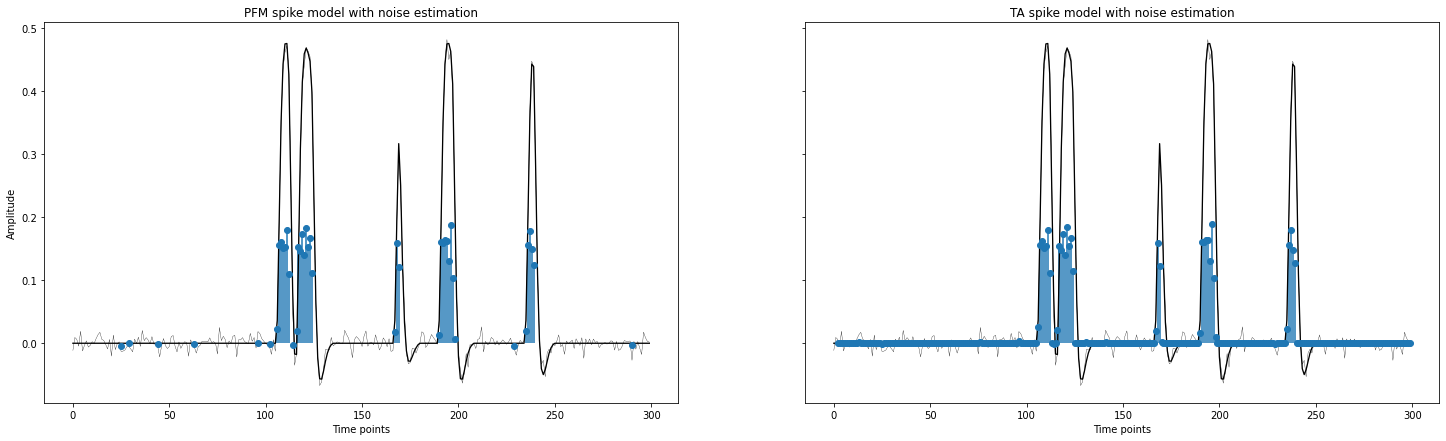

In [51]:
# Set zeros to nan to make plots cleaner.
pfm_spikes_plot = pfm_spikes.copy()
pfm_spikes_plot[pfm_spikes_plot == 0] = np.nan
ta_spikes_plot = ta_spikes.copy()
ta_spikes_plot[ta_spikes_plot == 0] = np.nan

# Generate figure.
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,7))

# Plot PFM results
ax1.plot(y, color='black', linewidth=.3, label='Simulation')
ax1.plot(ground_truth, color='black', linewidth='1.3', label='Ground truth')
ax1.stem(pfm_spikes_plot, label='PFM', use_line_collection=True, basefmt=" ")
ax1.set(xlabel='Time points', ylabel='Amplitude')
ax1.set_title('PFM spike model with noise estimation')

# Plot TA results
ax2.plot(y, color='black', linewidth=.3, label='Simulation')
ax2.plot(ground_truth, color='black', linewidth='1.3', label='Ground truth')
ax2.stem(ta_spikes_plot, label='TA', use_line_collection=True, basefmt=" ")
ax2.set(xlabel='Time points')
ax2.set_title('TA spike model with noise estimation')

In [46]:
# Generate HRF filter for TA with block model
params['model'] = 'block'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'])
n = params['f_analyze']['num']
d = params['f_analyze']['den']

for vox_idx in range(1):
    
    # Extract voxel data
    y = data[:, vox_idx]
    y = y[:, np.newaxis]
    
    # Set lambda to the PFM BIC selection
    bic_lambda = lambdas_pfm_block[bic_pfm_block_idx]
    
    # Solve PFM. Lambda is divided by nscans to account for sklearn formulation.
    clf = Lasso(alpha=bic_lambda/nscans)
    clf.fit(hrf_block, y)
    pfm_block = clf.coef_
    
    # Solve TA
    ta_block, _ = ta(y, params, lambd=bic_lambda, update_lambda=False)

/Users/enekourunuela/pfm_vs_ta/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011591192252659248, tolerance: 0.00040919797280390447
  positive)
/Users/enekourunuela/pfm_vs_ta/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


Text(0.5, 1.0, 'TA block model with noise estimation')

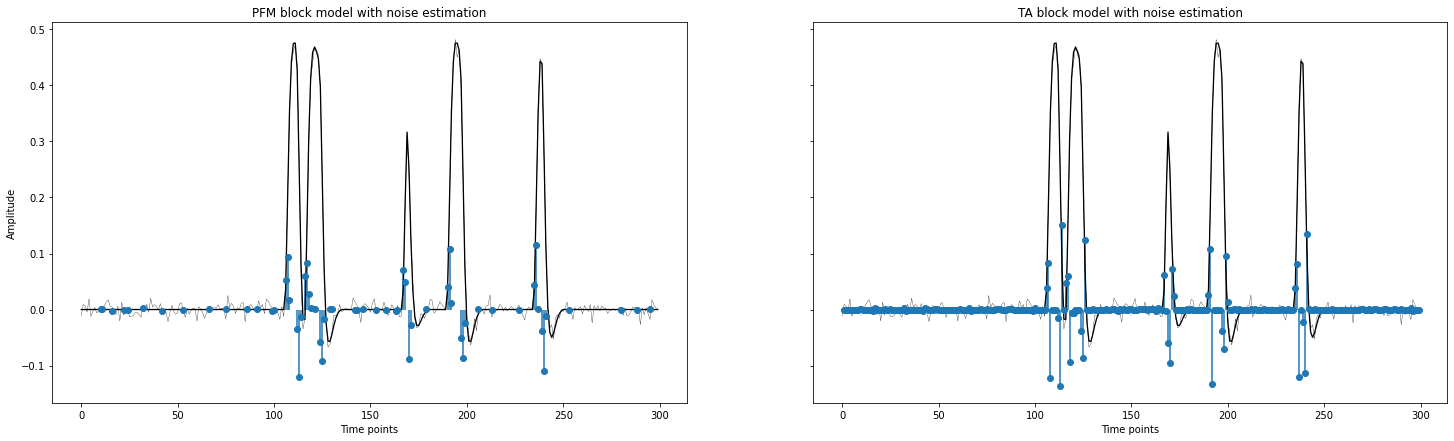

In [47]:
# Set zeros to nan to make plots cleaner.
pfm_block_plot = pfm_block
pfm_block_plot[pfm_block_plot == 0] = np.nan
ta_block_plot = ta_block
ta_block_plot[ta_block_plot == 0] = np.nan

# Generate figure.
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,7))

# Plot PFm results
ax1.plot(y, color='black', linewidth=.3, label='Simulation')
ax1.plot(ground_truth, color='black', linewidth='1.3', label='Ground truth')
ax1.stem(pfm_block_plot, label='PFM', use_line_collection=True, basefmt=" ")
ax1.set(xlabel='Time points', ylabel='Amplitude')
ax1.set_title('PFM block model with noise estimation')

# Plot TA results
ax2.plot(y, color='black', linewidth=.3, label='Simulation')
ax2.plot(ground_truth, color='black', linewidth='1.3', label='Ground truth')
ax2.stem(ta_block_plot, label='PFM', use_line_collection=True, basefmt=" ")
ax2.set(xlabel='Time points')
ax2.set_title('TA block model with noise estimation')

In [41]:
# Generate hrf filter for TA with block model
params['model'] = 'block'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'])
n = params['f_analyze']['num']
d = params['f_analyze']['den']

for vox_idx in range(1):
    
    # Extract voxel data
    y = data[:, vox_idx]
    y = y[:, np.newaxis]
    
    # Set lambda to TA BIC selection
    bic_lambda = lambdas_ta_block[bic_ta_block_idx]
    
    # Solve PFM. Lambda is divided by nscans to account for sklearn formulation.
    clf = Lasso(alpha=bic_lambda/nscans)
    clf.fit(hrf_block, y)
    pfm_block = clf.coef_
    
    # Solve TA
    ta_block, _ = ta(y, params, lambd=bic_lambda, update_lambda=False)

/Users/enekourunuela/pfm_vs_ta/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))
/Users/enekourunuela/pfm_vs_ta/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


Text(0.5, 1.0, 'TA block model with noise estimation')

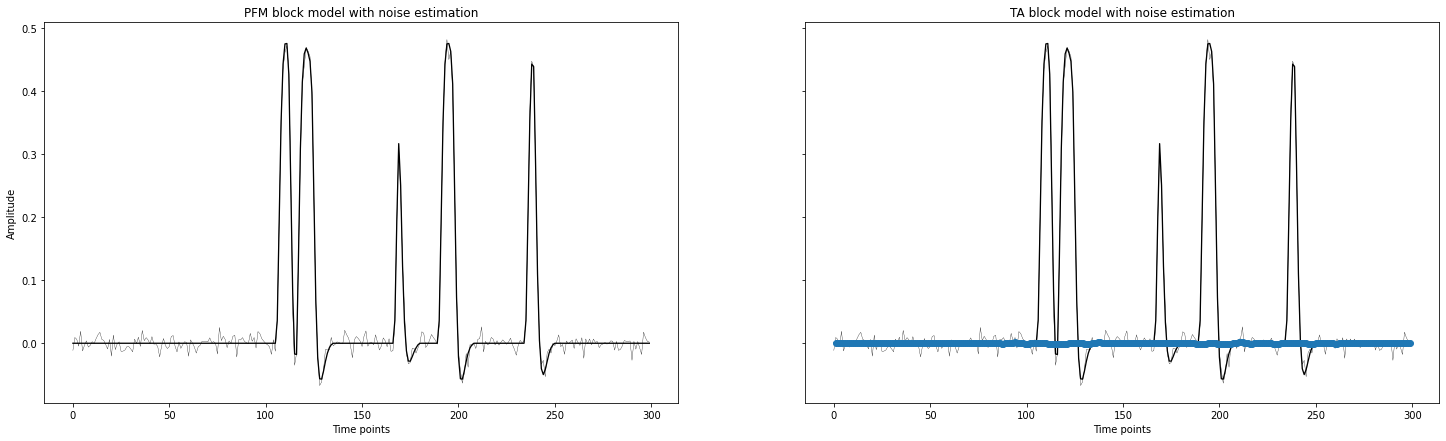

In [42]:
# Set zeros to nan to make plots cleaner.
pfm_block_plot = pfm_block
pfm_block_plot[pfm_block_plot == 0] = np.nan
ta_block_plot = ta_block
ta_block_plot[ta_block_plot == 0] = np.nan

# Generate figure.
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,7))

# Plot PFM results
ax1.plot(y, color='black', linewidth=.3, label='Simulation')
ax1.plot(ground_truth, color='black', linewidth='1.3', label='Ground truth')
ax1.stem(pfm_block_plot, label='PFM', use_line_collection=True, basefmt=" ")
ax1.set(xlabel='Time points', ylabel='Amplitude')
ax1.set_title('PFM block model with noise estimation')

# Plot TA results
ax2.plot(y, color='black', linewidth=.3, label='Simulation')
ax2.plot(ground_truth, color='black', linewidth='1.3', label='Ground truth')
ax2.stem(ta_block_plot, label='PFM', use_line_collection=True, basefmt=" ")
ax2.set(xlabel='Time points')
ax2.set_title('TA block model with noise estimation')